In [9]:
# Import libraries

using CSV, DataFrames, CategoricalArrays, Statistics, Gurobi, JuMP, Random, StatsBase, StatsModels, Plots, SparseArrays

# Preprocess

In [28]:
# Load data
df = CSV.read("miami.csv", DataFrame)
train_df = CSV.read("train_df.csv", DataFrame)
test_df = CSV.read("test_df.csv", DataFrame)
first(df, 1)

Row,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Year,Month,StartHour,DurationMinutes,HighSeverity,lat_bin,lng_bin,location_id,DayOfWeek__Tuesday,DayOfWeek__Wednesday,DayOfWeek__Thursday,DayOfWeek__Friday,DayOfWeek__Saturday,DayOfWeek__Sunday,County__Miami_Dade,Airport_Code__KHWO,Airport_Code__KMIA,Airport_Code__KOPF,Airport_Code__KTMB,Wind_Direction__E,Wind_Direction__ENE,Wind_Direction__ESE,Wind_Direction__N,Wind_Direction__NE,Wind_Direction__NNE,Wind_Direction__NNW,Wind_Direction__NW,Wind_Direction__S,Wind_Direction__SE,Wind_Direction__SSE,Wind_Direction__SSW,Wind_Direction__SW,Wind_Direction__VAR,Wind_Direction__W,Wind_Direction__WNW,Wind_Direction__WSW,Weather_Condition__Cloudy_Windy,Weather_Condition__Fair,Weather_Condition__Fair_Windy,Weather_Condition__Fog,Weather_Condition__Haze,Weather_Condition__Heavy_Rain,Weather_Condition__Heavy_Rain_Windy,Weather_Condition__Heavy_T_Storm,Weather_Condition__Heavy_T_Storm_Windy,Weather_Condition__Light_Drizzle,Weather_Condition__Light_Rain,Weather_Condition__Light_Rain_Windy,Weather_Condition__Light_Rain_with_Thunder,Weather_Condition__Mostly_Cloudy,Weather_Condition__Mostly_Cloudy_Windy,Weather_Condition__Partly_Cloudy,Weather_Condition__Partly_Cloudy_Windy,Weather_Condition__Rain,Weather_Condition__Rain_Windy,Weather_Condition__Shallow_Fog,Weather_Condition__Smoke,Weather_Condition__Squalls_Windy,Weather_Condition__T_Storm,Weather_Condition__T_Storm_Windy,Weather_Condition__Thunder,Weather_Condition__Thunder_Windy,Weather_Condition__Thunder_in_the_Vicinity,Sunrise_Sunset__Night,Civil_Twilight__Night,Nautical_Twilight__Night,Astronomical_Twilight__Night,HighSeverity_int
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Float64,Float64,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,25.8489,-80.2077,25.8489,-80.2079,0.011,75.0,75.0,64.0,30.09,10.0,3.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,2023,2,9,360.0,0,25.85,-80.21,25.85_-80.21000000000001,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
# Build a geographic decision grid, about 1 sq. km

# Choose grid resolution
grid_size = 0.01   # degrees (approx. 1 km)

# Create binned coordinates
df.lat_bin = round.(df.Start_Lat ./ grid_size) .* grid_size
df.lng_bin = round.(df.Start_Lng ./ grid_size) .* grid_size

# Create unique identifier
df.location_id = string.(df.lat_bin) .* "_" .* string.(df.lng_bin)
first(df, 1)

Row,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Year,Month,StartHour,DurationMinutes,HighSeverity,lat_bin,lng_bin,location_id,DayOfWeek__Tuesday,DayOfWeek__Wednesday,DayOfWeek__Thursday,DayOfWeek__Friday,DayOfWeek__Saturday,DayOfWeek__Sunday,County__Miami_Dade,Airport_Code__KHWO,Airport_Code__KMIA,Airport_Code__KOPF,Airport_Code__KTMB,Wind_Direction__E,Wind_Direction__ENE,Wind_Direction__ESE,Wind_Direction__N,Wind_Direction__NE,Wind_Direction__NNE,Wind_Direction__NNW,Wind_Direction__NW,Wind_Direction__S,Wind_Direction__SE,Wind_Direction__SSE,Wind_Direction__SSW,Wind_Direction__SW,Wind_Direction__VAR,Wind_Direction__W,Wind_Direction__WNW,Wind_Direction__WSW,Weather_Condition__Cloudy_Windy,Weather_Condition__Fair,Weather_Condition__Fair_Windy,Weather_Condition__Fog,Weather_Condition__Haze,Weather_Condition__Heavy_Rain,Weather_Condition__Heavy_Rain_Windy,Weather_Condition__Heavy_T_Storm,Weather_Condition__Heavy_T_Storm_Windy,Weather_Condition__Light_Drizzle,Weather_Condition__Light_Rain,Weather_Condition__Light_Rain_Windy,Weather_Condition__Light_Rain_with_Thunder,Weather_Condition__Mostly_Cloudy,Weather_Condition__Mostly_Cloudy_Windy,Weather_Condition__Partly_Cloudy,Weather_Condition__Partly_Cloudy_Windy,Weather_Condition__Rain,Weather_Condition__Rain_Windy,Weather_Condition__Shallow_Fog,Weather_Condition__Smoke,Weather_Condition__Squalls_Windy,Weather_Condition__T_Storm,Weather_Condition__T_Storm_Windy,Weather_Condition__Thunder,Weather_Condition__Thunder_Windy,Weather_Condition__Thunder_in_the_Vicinity,Sunrise_Sunset__Night,Civil_Twilight__Night,Nautical_Twilight__Night,Astronomical_Twilight__Night,HighSeverity_int
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Float64,Float64,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,25.8489,-80.2077,25.8489,-80.2079,0.011,75.0,75.0,64.0,30.09,10.0,3.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,2023,2,9,360.0,0,25.85,-80.21,25.85_-80.21000000000001,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
# Assign predicted risk to each accident
y_hat = CSV.read("sparseyhat_octhrecall.csv", DataFrame)
df.pred_prob = y_hat.prob_class1
first(df, 1)

Row,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Year,Month,StartHour,DurationMinutes,HighSeverity,lat_bin,lng_bin,location_id,DayOfWeek__Tuesday,DayOfWeek__Wednesday,DayOfWeek__Thursday,DayOfWeek__Friday,DayOfWeek__Saturday,DayOfWeek__Sunday,County__Miami_Dade,Airport_Code__KHWO,Airport_Code__KMIA,Airport_Code__KOPF,Airport_Code__KTMB,Wind_Direction__E,Wind_Direction__ENE,Wind_Direction__ESE,Wind_Direction__N,Wind_Direction__NE,Wind_Direction__NNE,Wind_Direction__NNW,Wind_Direction__NW,Wind_Direction__S,Wind_Direction__SE,Wind_Direction__SSE,Wind_Direction__SSW,Wind_Direction__SW,Wind_Direction__VAR,Wind_Direction__W,Wind_Direction__WNW,Wind_Direction__WSW,Weather_Condition__Cloudy_Windy,Weather_Condition__Fair,Weather_Condition__Fair_Windy,Weather_Condition__Fog,Weather_Condition__Haze,Weather_Condition__Heavy_Rain,Weather_Condition__Heavy_Rain_Windy,Weather_Condition__Heavy_T_Storm,Weather_Condition__Heavy_T_Storm_Windy,Weather_Condition__Light_Drizzle,Weather_Condition__Light_Rain,Weather_Condition__Light_Rain_Windy,Weather_Condition__Light_Rain_with_Thunder,Weather_Condition__Mostly_Cloudy,Weather_Condition__Mostly_Cloudy_Windy,Weather_Condition__Partly_Cloudy,Weather_Condition__Partly_Cloudy_Windy,Weather_Condition__Rain,Weather_Condition__Rain_Windy,Weather_Condition__Shallow_Fog,Weather_Condition__Smoke,Weather_Condition__Squalls_Windy,Weather_Condition__T_Storm,Weather_Condition__T_Storm_Windy,Weather_Condition__Thunder,Weather_Condition__Thunder_Windy,Weather_Condition__Thunder_in_the_Vicinity,Sunrise_Sunset__Night,Civil_Twilight__Night,Nautical_Twilight__Night,Astronomical_Twilight__Night,HighSeverity_int,pred_prob
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Float64,Float64,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64
1,25.8489,-80.2077,25.8489,-80.2079,0.011,75.0,75.0,64.0,30.09,10.0,3.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,2023,2,9,360.0,0,25.85,-80.21,25.85_-80.21000000000001,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.188647


In [31]:
# Aggregate risk by Location

# Group by grid location
grouped = combine(
    groupby(df, :location_id),
    [
        :pred_prob => length => :n_accidents,
        :pred_prob => mean   => :mean_risk,
        :pred_prob => sum    => :total_risk
    ]
)
first(grouped,1)

Row,location_id,n_accidents,mean_risk,total_risk
,String,Int64,Float64,Float64
1,25.85_-80.21000000000001,1152,0.338995,390.522


# Optimize!

# Baseline

### Predictive–Prescriptive Optimization for Police Resource Allocation

We consider a predictive–prescriptive framework to allocate limited police/EMS resources across Miami–Dade.

#### Predictive stage

From Part A, we trained a predictive model (logistic regression / sparse regression / OCT) to estimate, for each historical accident \(i\),

$
\hat{p}_i = \mathbb{P}(\text{HighSeverity}_i = 1 \mid \text{features of accident } i).
$

We discretize the Miami–Dade area into approximately 840 grid cells, each about \(1 \text{ km}^2\), and assign each accident to a cell based on its latitude/longitude. Let \(j \in \{1,\dots,J\}\) index grid cells and let \(D_j\) be the set of accidents that occurred in cell \(j\).

We define the **grid-level severe-accident risk** as

$
w_j = \sum_{i \in D_j} \hat{p}_i,
$

which can be interpreted as the expected number of severe accidents that occur in cell \(j\) over the historical period (or per year, if normalized).

#### Prescriptive stage (basic model)

Now we want to allocate a limited number of police/EMS units across these grid cells so that the units are positioned in the highest-risk locations. In this basic model, we assume:

- Each grid cell \(j\) can either have a dedicated unit or not.
- A unit assigned to cell \(j\) “covers” only that cell (no spillover to neighbors).
- We have a budget of at most \(K\) units in total.

Let the decision variable be

$
x_j =
\begin{cases}
1 & \text{if we assign a unit to grid cell } j, \\
0 & \text{otherwise}.
\end{cases}
$

Our goal is to **maximize the total severe-accident risk in covered cells**, subject to a budget on the number of units:

$
\max_{x} \quad \sum_{j=1}^J w_j x_j
$

subject to

$
\sum_{j=1}^J x_j \le K,
$

$
x_j \in \{0, 1\}, \quad \forall j = 1,\dots,J.
$

This is a simple 0–1 linear optimization problem that chooses up to \(K\) grid cells with the largest marginal benefit (as measured by \(w_j\)). The objective value

$
\sum_{j=1}^J w_j x_j
$

is the **total expected number of severe accidents covered by the deployed units**, according to our predictive model.

In later extensions, we can:

- Allow units to cover cells within a radius (maximal covering formulation),
- Impose additional constraints (e.g., fairness across neighborhoods, maximum units per region),
- Or evaluate the selected cells on a hold-out test set to measure how many severe accidents would actually fall inside the chosen grids.

In [33]:
# Aggregate accident-level predictions to grid-level risk w_j

# Assumptions:
# - df has one row per accident
# - df.location_id :: String or Symbol identifying the grid cell
# - df.pred_prob :: Float64, predicted P(HighSeverity = 1) for that accident

grouped = combine(
    groupby(df, :location_id),
    [
        :pred_prob => length => :n_accidents,   # total # accidents in cell j
        :pred_prob => sum    => :total_risk     # w_j = sum of predicted severe probs
    ]
)

# grouped now has:
# :location_id, :n_accidents, :total_risk

# Build and solve the prescriptive optimization model

# Extract vectors for JuMP
locations = grouped.location_id           # grid IDs, j = 1,...,J
w        = grouped.total_risk             # w_j = expected severe accidents in each grid
J = length(locations)

# Choose resource budget: number of units you can deploy
K = 20  

# Build the model
model = Model(Gurobi.Optimizer)
set_silent(model)  # comment out if we want solver logs

# Decision variable:
# x[j] = 1 if we assign a unit to grid cell j, 0 otherwise
@variable(model, x[1:J], Bin)

# Budget constraint: can assign units to at most K grid cells
@constraint(model, sum(x[j] for j in 1:J) <= K)

# Objective: maximize the total severe-accident risk in cells that get a unit
# This matches: max sum_j w_j * x_j
@objective(model, Max, sum(w[j] * x[j] for j in 1:J))

# Solve the model
optimize!(model)

# Extract and interpret the solution

# Indices of chosen grid cells
chosen_idx = [j for j in 1:J if value(x[j]) > 0.5]

# Mark selection back on the grouped DataFrame
grouped.selected = fill(0, nrow(grouped))
grouped.selected[chosen_idx] .= 1

# Total risk across all grids
total_risk_all = sum(grouped.total_risk)

# Risk covered by selected grids
covered_risk = sum(grouped.total_risk[j] for j in chosen_idx)

# Fraction of total risk captured by the K chosen grids
frac_covered = covered_risk / total_risk_all

println("=== Prescriptive Optimization Results ===")
println("Budget K (max units):       ", K)
println("Number of grids selected:   ", length(chosen_idx))
println("Objective value (risk):     ", objective_value(model))
println("Total risk (all grids):     ", total_risk_all)
println("Risk covered by selection:  ", covered_risk)
println("Fraction of risk covered:   ", round(frac_covered * 100, digits=2), "%")

println("\nTop selected locations (by risk):")
display(sort(grouped[grouped.selected .== 1, :], :total_risk, rev=true))

Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20
=== Prescriptive Optimization Results ===
Budget K (max units):       20
Number of grids selected:   20
Objective value (risk):     9152.651460170913
Total risk (all grids):     46194.22607244145
Risk covered by selection:  9152.651460170913
Fraction of risk covered:   19.81%

Top selected locations (by risk):


Row,location_id,n_accidents,total_risk,selected
,String,Int64,Float64,Int64
1,25.7_-80.38,1849,590.943,1
2,25.69_-80.42,1720,572.389,1
3,25.75_-80.34,1670,539.492,1
4,25.94_-80.19,1502,510.546,1
5,25.810000000000002_-80.31,1533,501.814,1
6,25.95_-80.15,1516,479.578,1
7,25.73_-80.34,1436,470.656,1
8,25.88_-80.21000000000001,1398,467.222,1
9,25.69_-80.37,1440,461.146,1


## Baseline Prescriptive Model

In this baseline model, we want to answer a simple question:

**“If we can place K safety units anywhere in Miami-Dade, which K grid cells should we choose to cover the largest amount of predicted severe-accident risk?”**

We start with accident-level predictions from our risk model. For each grid cell, we **sum the predicted probabilities of high-severity accidents**, giving us a number:

- **w_j = expected number of severe accidents in grid cell j**

A higher $ w_j $ means the cell contributes more to overall severe-accident risk.

The optimization model is intentionally very simple:

- Let **x_j = 1** if we place a resource in grid cell j, **0 otherwise**.
- We are allowed to select at most **K** grid cells.
- We maximize the total risk covered:

$
\max \sum_j w_j x_j
$

Because there are no geometric constraints, this model simply selects the **top K cells with the highest total predicted risk**. It is a pure “pick the highest values” model.

## Why This Is Only a Baseline

This model ignores many real-world factors:

- **No spatial coverage:** A unit only covers the exact cell it sits in.  
- **No travel time or response radius:** Units do not help nearby cells.  
- **No diminishing returns:** Adjacent hotspots may get multiple units even if unnecessary.  
- **No fairness or equity considerations:** All risk is treated equally.  
- **No temporal patterns:** We ignore differences across months or seasons.

Because of these simplifications, the baseline is **not an operational model**.  
However, it is extremely important because it tells us:

- How much risk we can capture in the best-case scenario.  
- How concentrated severe-accident risk is in the city.  
- How later, more realistic models compare to this unconstrained ideal.

Every advanced model (coverage radius, fairness constraints, seasonal variability, etc.) will be compared to this baseline to understand the trade-offs.

## Baseline Results

**Budget (K):** 20  
**Total predicted severe-accident risk:** 46194
**Risk covered by selected 20 cells:** 9152
**Percentage of total risk covered:** 19.81%

These results show how much of Miami-Dade’s severe-accident risk can be captured using a simple top-K allocation strategy. This serves as the foundation for building more realistic and impactful prescriptive models.

# Coverage–Budget Frontier

### Evaluating Prescriptive Policies Across Different Budgets

To understand how the number of deployable police/EMS units affects coverage of severe-accident risk, we evaluate the prescriptive optimization model across multiple budget levels:

$
K \in \{5, 10, 20, 50, 100\}.
$

For each value of \(K\):

1. We solve the maximization problem  
   $
   \max \sum_{j=1}^J w_j x_j
   \quad \text{s.t.} \quad
   \sum_{j=1}^J x_j \le K,\;
   x_j \in \{0,1\}.
   $

2. We record:
   - The optimal objective value (total severe-risk covered)
   - Total risk in all grids
   - The fraction of risk covered
   - The number of selected grid cells (always \(K\) except for small edge cases)

This allows us to plot a **coverage curve** showing how much severe-accident risk can be covered as we increase the resource budget.

In [34]:
# Extract data
locations = grouped.location_id
w         = grouped.total_risk
J = length(locations)

total_risk_all = sum(w)

# Budgets to evaluate
Ks = [5, 10, 20, 50, 100]

# Results DataFrame
results = DataFrame(
    K = Int[],
    objective = Float64[],
    covered_risk = Float64[],
    total_risk = Float64[],
    frac_covered = Float64[]
)

# Loop through each K and solve the model

for K in Ks
    model = Model(Gurobi.Optimizer)
    set_silent(model)

    @variable(model, x[1:J], Bin)
    @constraint(model, sum(x[j] for j in 1:J) <= K)
    @objective(model, Max, sum(w[j] * x[j] for j in 1:J))

    optimize!(model)

    # Extract chosen indices
    chosen_idx = [j for j in 1:J if value(x[j]) > 0.5]
    covered_risk = sum(w[j] for j in chosen_idx)

    push!(results, (
        K,
        objective_value(model),
        covered_risk,
        total_risk_all,
        covered_risk / total_risk_all
    ))
end

println("\n=== Multi-Budget Evaluation Results ===")
display(results)

Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20
Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20
Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20
Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20
Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20

=== Multi-Budget Evaluation Results ===


Row,K,objective,covered_risk,total_risk,frac_covered
,Int64,Float64,Float64,Float64,Float64
1,5,2715.18,2715.18,46194.2,0.0587776
2,10,5045.77,5045.77,46194.2,0.10923
3,20,9152.65,9152.65,46194.2,0.198134
4,50,17638.8,17638.8,46194.2,0.381839
5,100,26769.8,26769.8,46194.2,0.579506


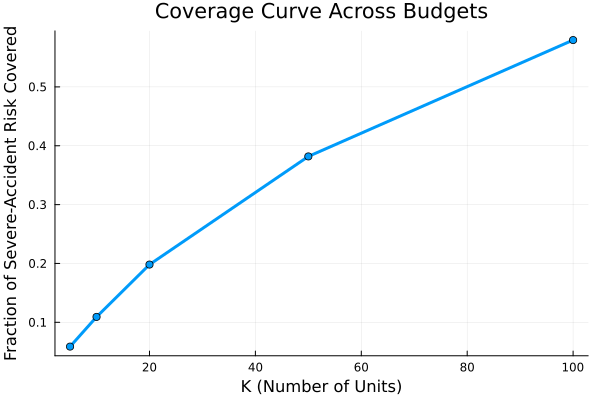

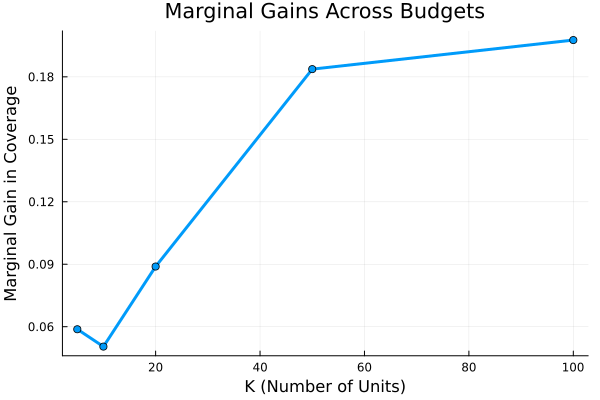

In [35]:
results_slim = select(results, :K, :frac_covered)

# Vectors for plotting
K_vec   = results_slim.K
cov_vec = results_slim.frac_covered

coverage_plot = plot(
    K_vec, cov_vec;
    xlabel = "K (Number of Units)",
    ylabel = "Fraction of Severe-Accident Risk Covered",
    title  = "Coverage Curve Across Budgets",
    lw = 3, marker = :circle, legend = false
)
display(coverage_plot)

# Marginal gains if you want them
marginal_gain = [cov_vec[1]; diff(cov_vec)]
marginal_plot = plot(
    K_vec, marginal_gain;
    xlabel = "K (Number of Units)",
    ylabel = "Marginal Gain in Coverage",
    title  = "Marginal Gains Across Budgets",
    lw = 3, marker = :circle, legend = false
)
display(marginal_plot)

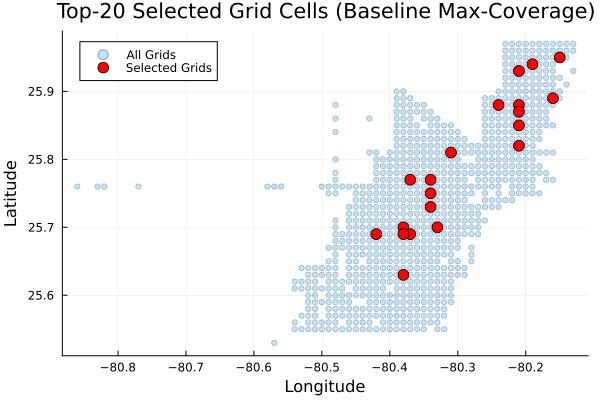

In [36]:
# Parse lat/lon from location_id once
function parse_lat_lon(id::AbstractString)
    parts = split(id, "_")  # adjust if your delimiter differs
    return parse(Float64, parts[1]), parse(Float64, parts[2])
end

latlon = map(parse_lat_lon, grouped.location_id)
grouped.lat = first.(latlon)
grouped.lon = last.(latlon)

# Choose a budget K and mark top-K cells by weight
K = 20  # change as needed
idx = partialsortperm(grouped.total_risk, 1:K; rev=true)  # indices of top-K w

grouped.selected = zeros(Int, nrow(grouped))
grouped.selected[idx] .= 1

selected = grouped[grouped.selected .== 1, :]

# Plot: all grids faint, selected in red
scatter(
    grouped.lon, grouped.lat;
    markersize = 3, alpha = 0.25, label = "All Grids",
    xlabel = "Longitude", ylabel = "Latitude",
    title = "Top-$K Selected Grid Cells (Baseline Max-Coverage)",
    aspect_ratio = :equal, legend = :topleft
)
scatter!(
    selected.lon, selected.lat;
    markersize = 6, color = :red, label = "Selected Grids"
)

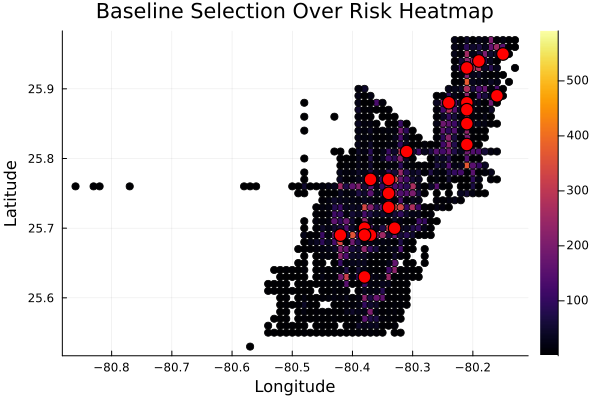

In [37]:
# Make sure c is a vector
cvals = collect(grouped.total_risk)

# Base heatmap-style scatter
p = scatter(
    grouped.lon,
    grouped.lat,
    marker_z = cvals,        
    markersize = 4,
    colorbar = true,
    xlabel = "Longitude",
    ylabel = "Latitude",
    title = "Baseline Selection Over Risk Heatmap",
    legend = false
)

# Overlay selected grids
scatter!(
    grouped.lon[grouped.selected .== 1],
    grouped.lat[grouped.selected .== 1],
    color = :red,
    markersize = 7,
    markerstrokewidth = 1.5,
    label = "Selected Grids"
)

display(p)

Each cell has a number that says how much severe-accident risk it has (w_j). We place K dots (units) on K cells for EMS to help people in severe accidents. We want to put those dots where they cover the most risk.

In the baseline, there’s no radius or elaborate “coverage” rule, we just pick the K cells with the biggest risk numbers. So the model’s job is to choose K that give the largest total risk when you add their numbers up.

Blue dots = all grid cells

Red dots = the K highest-risk cells (the ones the baseline chose)

We see red dots clustered in the hottest (most risky) parts of the map, the cells with the biggest w_j.

For each K (like 5, 10, 20, 50, 100), we solve:

“choose up to K cells” (@constraint(sum(x) ≤ K))

“maximize total risk” (@objective(Max, sum(w[j]*x[j])))

In this baseline, the solver basically ends up picking the top-K by w. We observe extremely strong spatial concentration in predicted severe-accident risk. Despite having ~840 1km² grid cells, expanding the resource budget from K=20 to K=50 covers over half the predicted risk, and K=100 covers nearly 58%. This demonstrates steep diminishing returns and highlights how a small set of targeted deployments can produce outsized improvements in coverage.

[ Info: Saved animation to /Users/AyelaChughtai/15.095/Project/baseline_selection_progress.gif


Plots.AnimatedGif("/Users/AyelaChughtai/15.095/Project/baseline_selection_progress.gif")
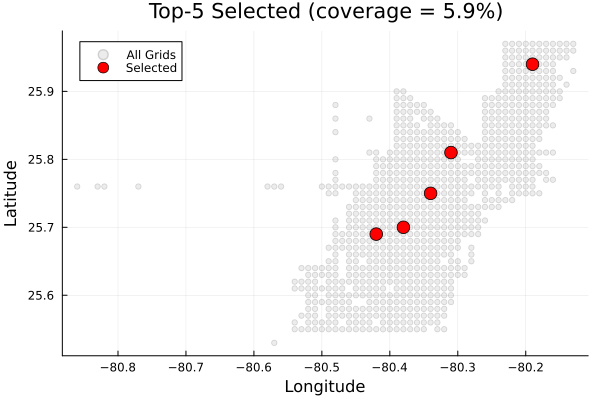

In [38]:
K_list = [5, 10, 20, 50, 100]
totrisk = sum(grouped.total_risk)

anim = @animate for K in K_list
    idx = partialsortperm(grouped.total_risk, 1:K; rev=true)
    frac = sum(grouped.total_risk[idx]) / totrisk

    p = scatter(grouped.lon, grouped.lat;
        ms=3, alpha=0.15, color=:gray, label="All Grids",
        xlabel="Longitude", ylabel="Latitude",
        aspect_ratio=:equal,
        title="Top-$K Selected (coverage = $(round(100*frac, digits=1))%)"
    )
    scatter!(grouped.lon[idx], grouped.lat[idx];
        ms=7, color=:red, label="Selected"
    )
    p
end

gif(anim, "baseline_selection_progress.gif", fps=1)

[ Info: Saved animation to /Users/AyelaChughtai/15.095/Project/baseline_selection_over_risk.gif


Plots.AnimatedGif("/Users/AyelaChughtai/15.095/Project/baseline_selection_over_risk.gif")
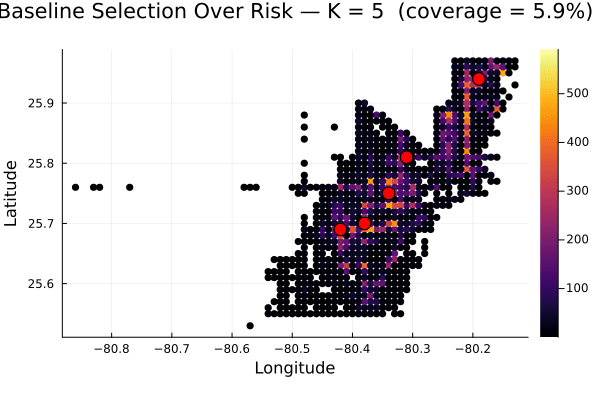

In [39]:
if !(:lat in names(grouped)) || !(:lon in names(grouped))
    function parse_lat_lon(id::AbstractString)
        parts = split(id, "_")  # adjust if your delimiter differs
        # if your ID is "lon_lat", swap the two lines below
        lat = parse(Float64, parts[1])
        lon = parse(Float64, parts[2])
        return lat, lon
    end
    latlon = map(parse_lat_lon, grouped.location_id)
    grouped.lat = first.(latlon)
    grouped.lon = last.(latlon)
end

risk = collect(grouped.total_risk)
lon  = grouped.lon
lat  = grouped.lat
K_list = [5, 10, 20, 50, 100]
totrisk = sum(risk)

# keep color scale fixed across frames
zmin, zmax = extrema(risk)

anim = @animate for K in K_list
    # Baseline: pick top-K by risk
    idx  = partialsortperm(risk, 1:K; rev=true)
    frac = sum(risk[idx]) / totrisk

    p = scatter(
        lon, lat;
        zcolor = risk, colorbar = true, c = :inferno, clims = (zmin, zmax),
        ms = 4, markerstrokewidth = 0,
        xlabel = "Longitude", ylabel = "Latitude",
        title = "Baseline Selection Over Risk — K = $K  (coverage = $(round(100*frac, digits=1))%)",
        legend = false, aspect_ratio = :equal
    )

    scatter!(lon[idx], lat[idx];
        ms = 7, color = :red, markerstrokecolor = :black, markerstrokewidth = 1.5
    )

    p
end

gif(anim, "baseline_selection_over_risk.gif", fps=1)


# Hold-Out Policy Evaluation of Prescriptive Policies

We train on **2018–2022** and evaluate decisions on the **2023** hold-out to test temporal generalization.  
For each budget $K \in \{5, 10, 20, 50, 100\}$, let $S(K)$ be the set of selected grid cells.

**Primary metric — Severe Coverage (2023):**  
What fraction of *actual* severe 2023 crashes fall inside the selected cells?
$$
\mathrm{SevereCoverage}(K)
= \frac{\#\{\,i \in 2023:\ \text{severity}_i=1,\ \text{grid}(i)\in S(K)\,\}}
       {\#\{\,i \in 2023:\ \text{severity}_i=1\,\}}.
$$

**Baselines (evaluated on 2023):**
- **Random \(K\)** cells (mean over 100 trials)
- **Historical hot-spots \(K\)** (top-\(K\) cells by **2018–2022** severe counts)

We report $\mathrm{SevereCoverage}(K)$ for **Our Policy**, **Random**, and **Historical**.  
Higher coverage than both baselines indicates the predictive–prescriptive approach finds **future** (2023) hot-spots better than chance or simply repeating the past.

Secondary check — Predicted Risk Coverage (2023):*

$$
\mathrm{RiskCoverage}(K)
= \frac{\sum_{i \in 2023,\ \text{grid}(i)\in S(K)} \hat{p}_i}
       {\sum_{i \in 2023} \hat{p}_i}.
$$

Row,K,ours,random,historical
,Int64,Float64,Float64,Float64
1,5,0.0714286,0.00678571,0.214286
2,10,0.0714286,0.01,0.357143
3,20,0.285714,0.0196429,0.571429
4,50,0.571429,0.0664286,0.571429
5,100,0.642857,0.121786,0.571429


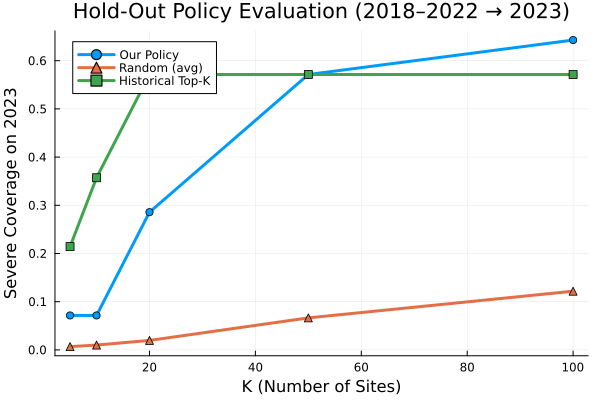

In [47]:
using DataFrames, StatsBase, Random, Plots

# assumes:
# train_df: 2018–2022 accidents with :location_id (String), :HighSeverity_int (0/1)
# test_df : 2023 accidents with :location_id (String), :HighSeverity_int (0/1)
# grouped : grid table with :location_id, :total_risk (Float64)

K_list = [5, 10, 20, 50, 100]
TRIALS = 200
Random.seed!(42)

# column aliases
ycol = :HighSeverity_int
idcol = :location_id

# policy weights and site ids
w       = collect(grouped.total_risk)
loc_ids = collect(grouped[!, idcol])
n_sites = length(loc_ids)

# our policy: top-K by model weight
function select_sites_ours(K::Int)
    return partialsortperm(w, 1:K; rev=true)  # indices of largest w
end

# historical baseline: top-K by 2018–2022 severe counts
hist_counts = combine(groupby(train_df, idcol), ycol => sum => :sev_hist)
hist_map = Dict(row[idcol] => row.sev_hist for row in eachrow(hist_counts))
sev_hist_aligned = [get(hist_map, id, 0) for id in loc_ids]
hist_order = sortperm(sev_hist_aligned; rev=true)
function select_sites_historical(K::Int)
    return hist_order[1:K]
end

# random baseline
function select_sites_random(K::Int)
    return randperm(n_sites)[1:K]
end

# severe coverage on 2023
test_severe = test_df[test_df[!, ycol] .== 1, :]
total_severe_2023 = nrow(test_severe)

function severe_coverage(selected_locids::Vector{String})
    S = Set(selected_locids)
    hits = sum(in(S), test_severe[!, idcol])
    return hits / max(1, total_severe_2023)
end

# evaluate across K
results = DataFrame(K=Int[], ours=Float64[], random=Float64[], historical=Float64[])

for K in K_list
    idx_ours = select_sites_ours(K)
    cov_ours = severe_coverage(loc_ids[idx_ours])

    cov_rand = mean(begin
        idx_r = select_sites_random(K)
        severe_coverage(loc_ids[idx_r])
    end for _ in 1:TRIALS)

    idx_hist = select_sites_historical(K)
    cov_hist = severe_coverage(loc_ids[idx_hist])

    push!(results, (K, cov_ours, cov_rand, cov_hist))
end

display(results)

# plot coverage vs K
p = plot(results.K, results.ours;
    xlabel="K (Number of Sites)",
    ylabel="Severe Coverage on 2023",
    title="Hold-Out Policy Evaluation (2018–2022 → 2023)",
    lw=3, marker=:circle, label="Our Policy"
)
plot!(results.K, results.random;     lw=3, marker=:utriangle, label="Random (avg)")
plot!(results.K, results.historical;  lw=3, marker=:square,   label="Historical Top-K")
display(p)


In [42]:
train_df

Row,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Year,Month,StartHour,DurationMinutes,HighSeverity,lat_bin,lng_bin,location_id,DayOfWeek__Tuesday,DayOfWeek__Wednesday,DayOfWeek__Thursday,DayOfWeek__Friday,DayOfWeek__Saturday,DayOfWeek__Sunday,County__Miami_Dade,Airport_Code__KHWO,Airport_Code__KMIA,Airport_Code__KOPF,Airport_Code__KTMB,Wind_Direction__E,Wind_Direction__ENE,Wind_Direction__ESE,Wind_Direction__N,Wind_Direction__NE,Wind_Direction__NNE,Wind_Direction__NNW,Wind_Direction__NW,Wind_Direction__S,Wind_Direction__SE,Wind_Direction__SSE,Wind_Direction__SSW,Wind_Direction__SW,Wind_Direction__VAR,Wind_Direction__W,Wind_Direction__WNW,Wind_Direction__WSW,Weather_Condition__Cloudy_Windy,Weather_Condition__Fair,Weather_Condition__Fair_Windy,Weather_Condition__Fog,Weather_Condition__Haze,Weather_Condition__Heavy_Rain,Weather_Condition__Heavy_Rain_Windy,Weather_Condition__Heavy_T_Storm,Weather_Condition__Heavy_T_Storm_Windy,Weather_Condition__Light_Drizzle,Weather_Condition__Light_Rain,Weather_Condition__Light_Rain_Windy,Weather_Condition__Light_Rain_with_Thunder,Weather_Condition__Mostly_Cloudy,Weather_Condition__Mostly_Cloudy_Windy,Weather_Condition__Partly_Cloudy,Weather_Condition__Partly_Cloudy_Windy,Weather_Condition__Rain,Weather_Condition__Rain_Windy,Weather_Condition__Shallow_Fog,Weather_Condition__Smoke,Weather_Condition__Squalls_Windy,Weather_Condition__T_Storm,Weather_Condition__T_Storm_Windy,Weather_Condition__Thunder,Weather_Condition__Thunder_Windy,Weather_Condition__Thunder_in_the_Vicinity,Sunrise_Sunset__Night,Civil_Twilight__Night,Nautical_Twilight__Night,Astronomical_Twilight__Night,HighSeverity_int
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Float64,Float64,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,-0.0717282,0.0327159,-0.105468,0.0336114,-0.25335,-0.103124,-0.101833,-0.216603,0.690505,0.210039,0.126138,-0.123875,0,0,0,0,0,0,0,0,0,0,0,0,0,2022,12,15,0.0034068,0,25.77,-80.3,25.77_-80.3,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-1.9575,-1.07442,-1.99937,-1.06872,-0.0669115,1.52231,1.51708,-0.991052,-0.143592,0.210039,0.52614,-0.123875,0,0,0,0,0,0,0,0,0,0,0,0,0,2022,8,17,0.00688791,0,25.58,-80.4,25.580000000000002_-80.4,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-1.9575,-1.07442,-1.94847,-1.06935,-0.421649,0.167781,0.167985,0.839465,-0.143592,0.210039,-1.87388,-0.123875,0,0,0,0,0,0,0,0,0,0,0,0,0,2022,6,7,0.00807881,0,25.58,-80.4,25.580000000000002_-80.4,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.893256,-1.11702,-0.877439,-1.09484,-0.336996,-1.45765,-1.45092,-1.6951,1.10755,0.210039,0.726141,-0.123875,0,0,0,0,0,0,0,0,0,0,0,0,0,2022,1,17,0.01669,0,25.68,-80.4,25.68_-80.4,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,-0.684251,-1.31157,-0.678222,-1.32126,-0.369245,0.167781,0.167985,1.26189,-2.02031,-0.559581,-0.473866,0.151723,0,0,0,0,0,0,0,0,0,0,0,0,0,2022,10,15,0.00817042,0,25.71,-80.42,25.71_-80.42,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0

In the 2018–2022 data and 2023 hold-out data, we compare severe-crash coverage for three policies across budgets K = {5, 10, 20, 50, 100}. Random selection covers very little (0.7%-12.2%), confirming that targeting matters. With very small budgets, Historical Top-K (pick past hot-spots) beats our model (e.g., K=5: 21.4% vs 7.1%; K=10: 35.7% vs 7.1%), showing 2023 severe crashes remain concentrated in a few persistent locations. As K increases, our model catches up and then surpasses history (tie at K=50: 57.1%; at K=100: ours 64.3% vs history 57.1%), indicating it captures additional or shifted 2023 risk beyond what past counts alone suggest. The curve shows diminishing returns after K=50, so that is a natural “elbow” unless the extra 7 percentage points from 50-100 justify the cost; a practical approach is hybrid—seed a few sites with historical hot-spots, then allocate remaining sites with the model to track emerging risk.

In [75]:
# Parse location_id into numeric lat/lng columns
function split_lat_lng(loc)
    parts = split(loc, "_")
    lat = parse(Float64, parts[1])
    lng = parse(Float64, parts[2])
    return lat, lng
end

latitudes  = Float64[]
longitudes = Float64[]

for loc in grouped.location_id
    lat, lng = split_lat_lng(loc)
    push!(latitudes, lat)
    push!(longitudes, lng)
end

grouped.lat_bin = latitudes
grouped.lng_bin = longitudes

840-element Vector{Float64}:
 -80.21000000000001
 -80.17
 -80.21000000000001
 -80.2
 -80.21000000000001
 -80.2
 -80.2
 -80.2
 -80.17
 -80.38
 -80.21000000000001
 -80.37
 -80.3
   ⋮
 -80.3
 -80.5
 -80.28
 -80.49
 -80.5
 -80.77
 -80.46000000000001
 -80.46000000000001
 -80.19
 -80.16
 -80.38
 -80.29

# Radius-based Coverage

### Radius-Based Coverage Model (Operational Siting)

We add a response radius so a unit placed at site $\ell$ covers any demand cell $j$ within $R$ km. Let $w_j$ be the predicted severe-accident risk in cell $j$. Decisions:
- $x_\ell \in \{0,1\}$: place a unit at site $\ell$
- $y_j \in \{0,1\}$: demand cell $j$ is covered by at least one selected site

Define an incidence matrix $A_{j\ell} = 1$ if $\text{dist}(j,\ell) \le R$ and $0$ otherwise. With budget $K$, we solve:
$$
\max_{x,y}\ \sum_j w_j\, y_j
\quad \text{s.t.} \quad
\sum_\ell x_\ell \le K,\ \ 
y_j \le \sum_\ell A_{j\ell} x_\ell \ \forall j,\ \ 
x_\ell \in \{0,1\},\ y_j \in \{0,1\}.
$$

**Interpretation:** Choose up to $K$ sites to maximize total risk covered within radius $R$. On the map: light points are all grid cells, green points are covered cells ($y_j=1$), and red points are selected sites ($x_\ell=1$). Larger $K$ or $R$ increases coverage but with diminishing returns; plot the coverage fraction $\sum_j w_j y_j / \sum_j w_j$ versus $K$ (for fixed $R$) to pick a budget that balances impact and cost.


Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20
Radius R = 3.0 km, budget K = 20
Selected sites: 20, covered cells: 492, coverage = 93.4%


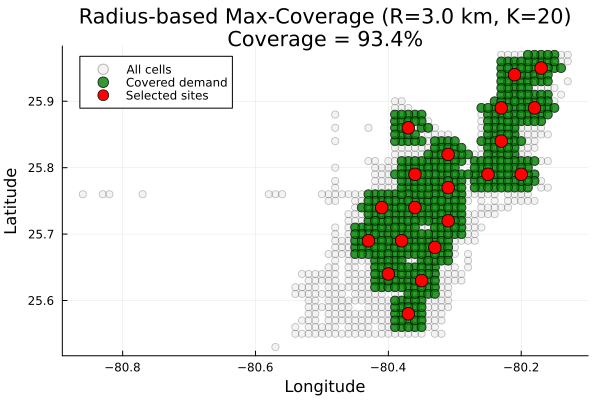

In [48]:
if !(:lat in names(grouped)) || !(:lon in names(grouped))
    function parse_lat_lon(id::AbstractString)
        p = split(id, "_")              
        return parse(Float64, p[1]), parse(Float64, p[2])
    end
    latlon = map(parse_lat_lon, grouped.location_id)
    grouped.lat = first.(latlon)
    grouped.lon = last.(latlon)
end

lat = grouped.lat
lon = grouped.lon
w   = grouped.total_risk |> collect
J   = length(w)

# build coverage incidence within radius R_km 
# crude but fine: great-circle approx via "111 km per degree" and cos(lat)
function approx_km(lat1, lon1, lat2, lon2)
    dx = (lat1 - lat2) * 111.0
    dy = (lon1 - lon2) * 111.0 * cosd((lat1 + lat2)/2)
    return sqrt(dx^2 + dy^2)
end

R_km = 3.0                           #operational radius
rows = Int[]; cols = Int[]; vals = Int[]
for j in 1:J, ℓ in 1:J
    if approx_km(lat[j], lon[j], lat[ℓ], lon[ℓ]) <= R_km
        push!(rows, j); push!(cols, ℓ); push!(vals, 1)
    end
end
A = sparse(rows, cols, vals, J, J)   # A[j,ℓ]=1 if site ℓ covers demand j

# solve max-coverage with radius for a chosen K
K = 20                                # budget

model = Model(Gurobi.Optimizer)
set_silent(model)

@variable(model, x[1:J], Bin)         # site decisions
@variable(model, y[1:J], Bin)         # covered-demand flags

@constraint(model, sum(x) <= K)
@constraint(model, [j in 1:J], y[j] <= sum(A[j,ℓ]*x[ℓ] for ℓ in 1:J))
@objective(model, Max, sum(w[j]*y[j] for j in 1:J))

optimize!(model)

sel = findall(>(0.5), value.(x))
cov = findall(>(0.5), value.(y))
frac = sum(w[cov]) / sum(w)

println("Radius R = $(R_km) km, budget K = $K")
println("Selected sites: $(length(sel)), covered cells: $(length(cov)), coverage = $(round(100*frac,digits=1))%")

# plot: covered cells (green) and chosen sites (red)
scatter(lon, lat; color=:lightgray, ms=4, alpha=0.25,
       xlabel="Longitude", ylabel="Latitude",
       title="Radius-based Max-Coverage (R=$(R_km) km, K=$K)\nCoverage = $(round(100*frac,digits=1))%",
       aspect_ratio=:equal, label="All cells")
scatter!(lon[cov], lat[cov]; color=:green, ms=5, alpha=0.8, label="Covered demand")
scatter!(lon[sel], lat[sel]; color=:red, ms=7, markerstrokecolor=:black, label="Selected sites")


Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20
Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20
Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20
Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20
Set parameter Username
Set parameter LicenseID to value 2697020
Academic license - for non-commercial use only - expires 2026-08-20


Row,K,frac_covered
,Int64,Float64
1,5,0.444709
2,10,0.701365
3,20,0.934193
4,50,1.0
5,100,1.0


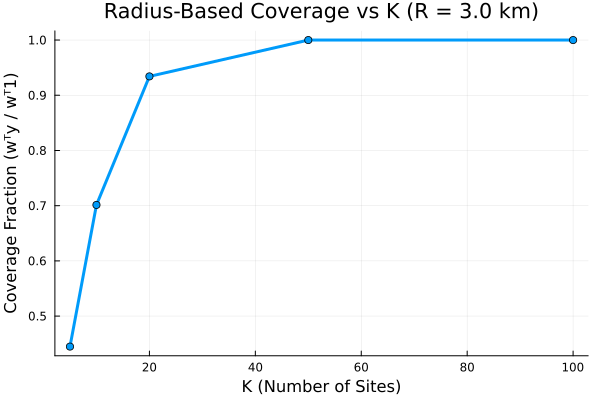

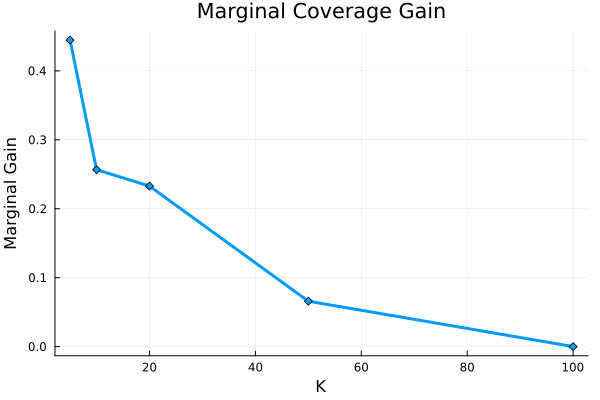

In [49]:
lat = grouped.lat
lon = grouped.lon
w   = collect(grouped.total_risk)
J   = length(w)
Wtot = sum(w)

# crude distance (km) using 111 km/deg
function approx_km(lat1, lon1, lat2, lon2)
    dx = (lat1 - lat2) * 111.0
    dy = (lon1 - lon2) * 111.0 * cosd((lat1 + lat2)/2)
    return sqrt(dx^2 + dy^2)
end

# build incidence A once for fixed R
R_km = 3.0
rows = Int[]; cols = Int[]; vals = Int[]
for j in 1:J, ℓ in 1:J
    if approx_km(lat[j], lon[j], lat[ℓ], lon[ℓ]) <= R_km
        push!(rows, j); push!(cols, ℓ); push!(vals, 1)
    end
end
A = sparse(rows, cols, vals, J, J)

# sweep K and record coverage fraction
K_list = [5, 10, 20, 50, 100]
results = DataFrame(K=Int[], frac_covered=Float64[])

for K in K_list
    model = Model(Gurobi.Optimizer)
    set_silent(model)

    @variable(model, x[1:J], Bin)             # site choices
    @variable(model, y[1:J], Bin)             # covered demand

    @constraint(model, sum(x) <= K)
    @constraint(model, [j in 1:J], y[j] <= sum(A[j,ℓ]*x[ℓ] for ℓ in 1:J))
    @objective(model, Max, sum(w[j]*y[j] for j in 1:J))

    optimize!(model)

    yval = value.(y)
    covered_idx = findall(>(0.5), yval)
    frac = sum(w[covered_idx]) / Wtot

    push!(results, (K, frac))
end

display(results)

# plot coverage fraction vs K
p = plot(results.K, results.frac_covered;
    xlabel = "K (Number of Sites)",
    ylabel = "Coverage Fraction (wᵀy / wᵀ1)",
    title  = "Radius-Based Coverage vs K (R = $(R_km) km)",
    lw=3, marker=:circle, legend=false
)
display(p)

# marginal gains plot
mg = [results.frac_covered[1]; diff(results.frac_covered)]
p2 = plot(results.K, mg; xlabel="K", ylabel="Marginal Gain", title="Marginal Coverage Gain", lw=3, marker=:diamond, legend=false)
display(p2)


With a 3 km response radius, the radius-based model covers most risk with relatively few sites and then saturates. At K=5, it covers 44.5% of total weighted risk; at K=10, 70.1%; at K=20, 93.4%; and by K=50 it reaches 100% (no further gain at K=100). The map shows that each selected site (red) covers a cluster of nearby demand cells (green), so early sites produce large gains because they sit in the densest hotspots; later sites add only small pockets of uncovered cells. The marginal-gain curve drops sharply (big jump from 5→10, smaller from 10 to 20, tiny by 20 to 50), indicating strong diminishing returns and a natural “elbow” around K=20–50. Practically, K=20 already achieves ~93% coverage; increasing to K=50 achieves full coverage, and additional sites beyond that do not improve coverage under this radius.